#Notebook: Fraud Detection — EDA + Baseline ML

Project: Fraud Detection Analysis
Goal: Identify patterns in fraudulent banking transactions and build a simple predictive model.
Dataset: [Fraud/Kaggle]
Tools: Python (pandas, numpy, seaborn, scikit-learn), Tableau, Excel
Structure:
1. EDA: Explore patterns and summarize insights
2. Visualizations: Clean, simple charts to highlight fraud trends
3. Machine Learning Prediction: Build baseline classifier to predict fraud
4. Recommendations: Insights & risk scoring

#O. Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)


#1.Load data

In [ ]:
data_path = "data:/raw/Fraud.csv"
df = pd.read_csv(data_path)
df.shape, df.columns.tolist()



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#2.Quick inspection

In [ ]:
df.head

In [6]:
# Basic info
df.info()

# Quick statistics
df.describe()

# Check missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df['isFraud'].value_counts(normalize=True)


0    0.998709
1    0.001291
Name: isFraud, dtype: float64

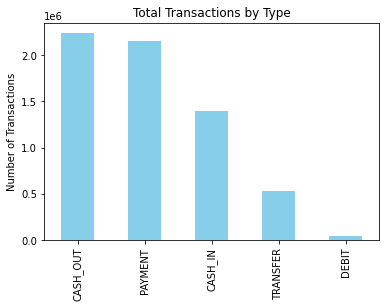

In [8]:
total_counts = df['type'].value_counts()
total_counts.plot(kind='bar', color='skyblue', title='Total Transactions by Type')
plt.ylabel('Number of Transactions')
plt.show()

0.19% of fraudulent transactions were flagged.


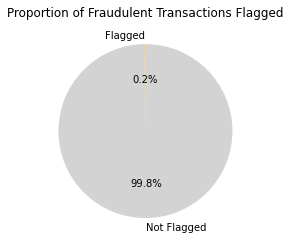

In [9]:
# Total frauds
total_frauds = df['isFraud'].sum()

# Frauds that were flagged
flagged_frauds = df[(df['isFraud'] == 1) & (df['isFlaggedFraud'] == 1)].shape[0]

# Percentage
percent_flagged = (flagged_frauds / total_frauds) * 100
print(f"{percent_flagged:.2f}% of fraudulent transactions were flagged.")

# Simple pie chart
sizes = [flagged_frauds, total_frauds - flagged_frauds]
labels = ['Flagged', 'Not Flagged']
colors = ['orange', 'lightgrey']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Proportion of Fraudulent Transactions Flagged")
plt.show()

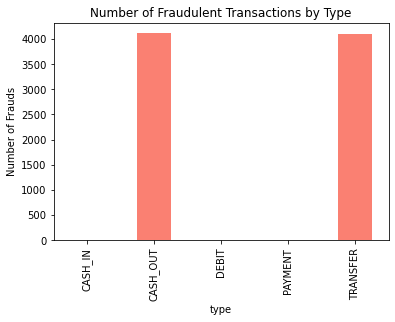

In [10]:
fraud_counts = df.groupby('type')['isFraud'].sum()
fraud_counts.plot(kind='bar', color='salmon', title='Number of Fraudulent Transactions by Type')
plt.ylabel('Number of Frauds')
plt.show()


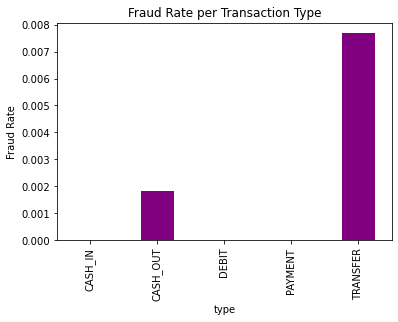

In [11]:
fraud_rate = df.groupby('type')['isFraud'].mean()
fraud_rate.plot(kind='bar', color='purple', title='Fraud Rate per Transaction Type')
plt.ylabel('Fraud Rate')
plt.show()



In [12]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:

X = df.drop(columns=['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'])
y = df['isFraud']


In [ ]:
X = pd.get_dummies(X, columns=['type'], drop_first=True)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]


In [ ]:
print("Classification report (test):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")


In [ ]:
# Plot confusion matrix (normalized)
import seaborn as sns
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Normalized Confusion Matrix (rows=true class)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_imp = importances.head(20)

top_imp.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.show()

print(top_imp)
